# Dimensionality Reduction using an Autoencoder
In this project, we will introduce the theory behind an autoencoder (AE), its uses, and its advantages over PCA, a common dimensionality reduction technique.

## Project Outline
[**Task 1**](#task1): Import Packages

[**Task 2**](#task2): Dataset Creation and Preprocessing

[**Task 3**](#task3): Create a Baseline Model with PCA

[**Task 4**](#task4): Autoencoder Introduction and Training

[**Task 5**](#task5): Reducing Dimensionality with AE

<a id='task1'></a>
# Task 1: Import Packages

In [1]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np

In [4]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error, silhouette_score

In [5]:
cols = ['#1FC17B', '#78FECF', '#555B6E', '#CC998D', '#429EA6',
        '#153B50', '#8367C7', '#EE6352', '#C287E8', '#F0A6CA', 
        '#521945', '#361F27', '#828489', '#9AD2CB', '#EBD494', 
        '#53599A', '#80DED9', '#EF2D56', '#446DF6', '#AF929D']

<a id='task2'></a>
# Task 2: Dataset Creation and Preprocessing

In this task, we will start creating our dataset and preprocess it so it will be ready for modelling. We will use a dataset that I create artificially for the specific problem. The way we do this is by using scikit learn's make_blob functions which essentially makes the distribution of data based on the parameters you give it.

In [6]:
# make_blob gives you back the X values of being the location of this data and y being a class label of this data.
# one of the parameters it make is the number of features which talks about the dimensionality of our data. 
# For this purpose, let's choose 50. We can use larger dimensionality but it'll take slightly longer to run.
# 50 is good amount considering we wil transform this in two dimensional space, it's a good trade off.
# Centers parameters pertains to how munay centers of data or how many different clusters
X, y = make_blobs(n_features=50, centers=20, # this translates to our data will have 50 dimensions accross 20 different classes or clusters.
                  n_samples=20000, # you can choose more but it make slightly longer to run. If you choose less, it may not be enough to train a good model.
                  cluster_std=0.2, # the standard deviation of the point between each of the centers.
                  center_box=[-1, 1], # not strictly necessary. We'll just use this to constrain our centers within reasonable location.
                  random_state=17) # for the sake of reproducibility so we can have the same data produced if we run this notebook again.

In [7]:
# check first item of X
X[0]

array([-0.24491985,  0.08099673, -0.36631058, -0.30356551,  0.4029225 ,
        0.65687067,  0.92734294,  0.15492068, -1.10501981,  1.2015462 ,
        0.09578114, -0.75648951, -0.03483697, -0.59523737,  0.02576486,
        0.53523807,  0.08089194, -0.26480015, -0.71277422,  0.07793643,
        0.10326661, -0.92311803, -0.18569531, -0.5761846 , -0.78765359,
       -0.83055169,  0.04446853, -0.26118528,  0.8337965 , -0.59227263,
        0.68834042,  0.17701281,  0.2732509 , -0.00538731,  0.92922794,
        0.62743183,  0.85424358,  0.80721711, -1.14219787,  0.28178435,
        0.55215801,  0.38500603,  0.19163107,  0.55960783,  0.72073584,
       -1.14520866,  1.09184982, -1.04337987,  1.24350139, -0.63786661])

We can see that it's a 50 diemnsional array.

In [10]:
# split the dataset for testing and training
# in cetain ML apps,you might have a validation and a test set, in our case we are just worried about two differnet validations
# considering that we know our dataset is coming from a uniform distribution, we're relatively confident.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=17)

# note that each centers could be located somewhere -1 and 1 in a square pattern in each of the 50 dimensions.

# scale the data
scaler = MinMaxScaler() # this will scale each feature. Meaning each dimension will be converted from its existing distribution to be a value between 0 and 1.

# fit the scaler and transform our test set
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

We've got our preprocessed data and ready for modelling.

<a id='task3'></a>
# Task 3: Baseline Model

We will use PCA to create a model as a baseline to see our performance.

In [11]:
pca = PCA(n_components=2) # because we've got 50 dimension of our data that we want to bring down to two dimension.
pca.fit(X_train)

#get the result of our transformed data
res_pca = pca.transform(X_test)

In [12]:
# check result
res_pca.shape

(2000, 2)

We can see its 2000 which is 10% of our data that we set as test data and two dimensions.

Text(0.5, 1.0, 'PCA Results')

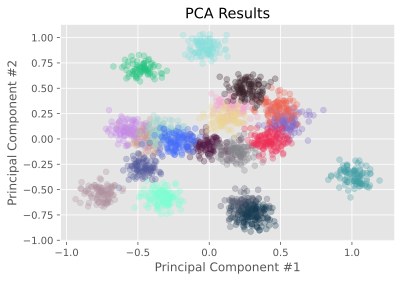

In [14]:
# loop each different clusters
unique_labels = np.unique(y_test)

for index, unique_labels in enumerate(unique_labels):
    X_data = res_pca[y_test==unique_labels]
    # plot the data
    plt.scatter(X_data[:,0], 
                X_data[:,1], # y-values refers to second dimension
                alpha=0.3, # this gives point in our scatterplot a slide transparency value
                c=cols[index]) # refers to the list of color we created earlier

# what PCA does is, when given a dataset in high dimensional space, in our case, 
# it will find the direction/vectors in the dataset with the highest variance. 
# The first component wil have the highest variance and everything will be 
# projected onto that component, othogonal to that you will find the next component 
# which will be our principal component 2.
plt.xlabel('Principal Component #1')
plt.ylabel('Principal Component #2')
plt.title('PCA Results')

Here we can see our dataset. It's quite interesting some classes are being retained. Some are being seperated from the rest. A couple of clusters in the middle seems to have overlap which could be an issue.

<a id='task4'></a>
# Task 4: Autoencoded Theory and Training

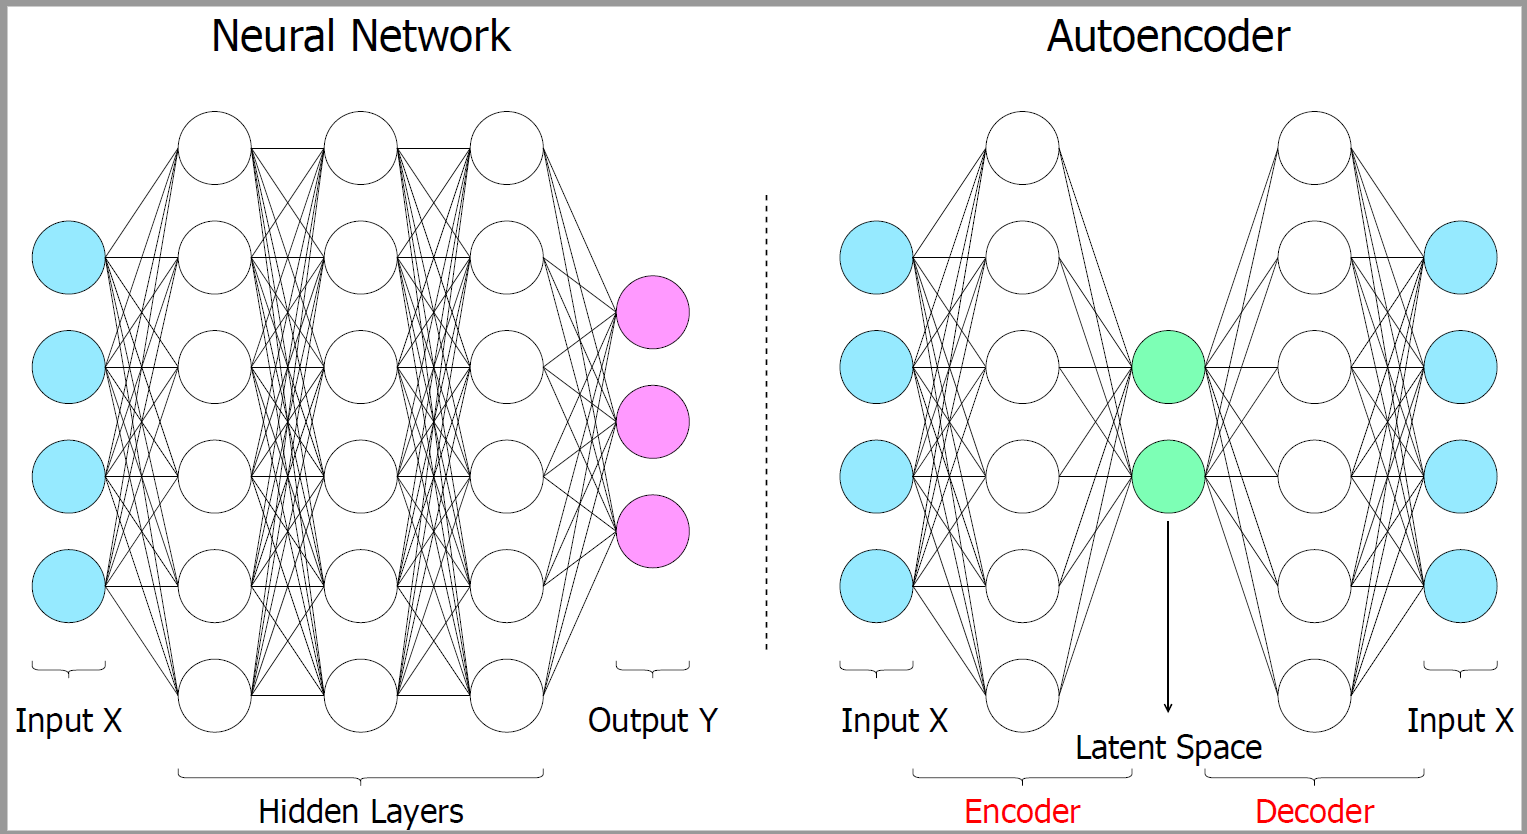

In [15]:
# we'll use Regressor function because this is no longer a classification task
# because our inputs are real value and it kinda acts like regression task like 
# you want to predict a vector values
autoencoder = MLPRegressor(alpha=1e-15, 
                           hidden_layer_sizes=(50, 100, 50, 2, 50, 100, 50), 
                           random_state=1, max_iter=20000)
# fit our training data
autoencoder.fit(X_train, X_train) # our input will be train data and our output will also be our train data.

MLPRegressor(alpha=1e-15, hidden_layer_sizes=(50, 100, 50, 2, 50, 100, 50),
             max_iter=20000, random_state=1)

<a id='task5'></a>
# Task 5: Reducing Dimensionality with Encoder

In [16]:
W = autoencoder.coefs_ # W represents weight
biases = autoencoder.intercepts_

In [17]:
for w in W:
    print(w.shape)

(50, 50)
(50, 100)
(100, 50)
(50, 2)
(2, 50)
(50, 100)
(100, 50)
(50, 50)


The first one will be 50 dimensional to 50.
The second is 50 to 100. And so on and so forth..

If we see this, we just care for the first four values. Anything after that is not necesarily relevant for us right now because that will cover the decoding section. We just worry for now about encoding our data to low dimensional space.

In [18]:
encoder_weights = W[0:4]
encoder_biases = biases[0:4]

In [21]:
# create a function where we can loop each of our ecoder weight and encoder biases
def encode(encoder_weights, encoder_biases, data):
    res_ae = data
    for index, (w, b) in enumerate(zip(encoder_weights, encoder_biases)):
        if index+1 == len(encoder_weights):
            res_ae = res_ae@w+b
        else:
            res_ae = np.maximum(0, res_ae@w+b)
            
    return res_ae

res_ae = encode(encoder_weights, encoder_biases, X_test) # X-test is our data that our model has not seen before training.
    
# This is our encoding function. Ths is what will take a 50 dimensional pice of data and convert it ot alist of 2 dimensional point

In [22]:
res_ae.shape

(2000, 2)

And we can see we got our 2000 samples each of two dimensions.

Text(0.5, 1.0, 'Autoencoder Results')

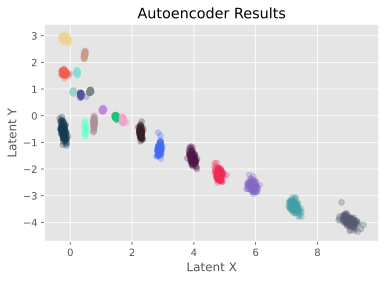

In [24]:
# Now that we completed our encoding function, we can now visualize our dataset in a very similar way that we did with PCA
unique_labels = np.unique(y_test)

for index, unique_label in enumerate(unique_labels):
    latent_space = res_ae[y_test == unique_label]
    
    plt.scatter(latent_space[:,0], latent_space[:,1], alpha=0.3, c=cols[index])
    
plt.xlabel('Latent X')
plt.ylabel('Latent Y')
plt.title('Autoencoder Results')

Our results looks very promising. From 6 to 8 in x-axis you immidiately see that our clusters are much stronger. They are significantly more independent and less interference accross the different clusters. This means our autoencoder work quite well. It managed to take 50 dimensions; compressed them into two dimensions and still maintains the information relevantin this dataset. Which was the class identification of each point. We can see that there seems no confusion. No point in a wrong cluster. We can conlcude that our autoencoder actually work quite well.

Now just by looking at the data between our PCA and our autoencoder, we can definitely see that the autoencoder has tended to find a better representation of 2 dimensional space. It is because each cluster is better defined in the autoencoder's latent space as opposed to PCA's two dimensional space.

One way of testing this is by using some theory behind clustering algorithm. This algorithm checks how well suit to the point is to the cluster it's been assigned to versus the neighboring cluster points.

Let us see how the score of our average silhouete scores.

In [28]:
# first, let's look at our original dataset.
silhouette_score(X_test, y_test)

0.6106327445141103

Our test set has 0.61 silhouete score. The way silhouete score works is, it scores from a __-1__ which means it's __poorly allocated__ to that cluster up to __+1__ whcih means its __perfect clustering__. And each point cannot be better clustered in another cluster where it is at the moment. The closer the value to 1, the better the clustering.

In [26]:
# Let's check how our PCA has done
silhouette_score(res_pca, y_test)

0.36442530830243663

Our result shows that our PCA peforms more poorly. It make sense because of overlap of point accross each cluster point.

In [27]:
# Now let's see how our autoencoder has done
silhouette_score(res_ae, y_test)

0.8020960810517915

We can actually see the big difference between the two. In terms of clustering, not necessariliy in our data itself, the fact of the goal of 1 point belonging to specific cluster, our autoencoder has better representation of the clusters than the orighinal data itself. That's quite an interesting finding.